SENSÖR VERİLERİNİN DAHA YAKIN OLDUĞU (İÇ İÇE GEÇMİŞ VERİLER)

GÖREV 1 -VERİYİ OLUŞTURMA-

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf

noise = 0.5
dataNum = 100
np.random.seed(42)
tf.random.set_seed(42)

states = {
    0: [0.0, 0.0, 1.0],   # Düz
    1: [0.0, 0.0, -1.0],  # Ters
    2: [0.0, 1.0, 0.0],   # Sağ
    3: [0.0, -1.0, 0.0],  # Sol
    4: [1.0, 0.0, 0.0],   # Arka (X+)
    5: [-1.0, 0.0, 0.0]   # Ön (X-)
}

X_list = []
y_list = []

for label, (x_mean, y_mean, z_mean) in states.items():
    # Her eksen için gürültülü veri üret
    ix = np.random.normal(x_mean, scale=noise, size=dataNum)
    iy = np.random.normal(y_mean, scale=noise, size=dataNum)
    iz = np.random.normal(z_mean, scale=noise, size=dataNum)
    
    # Birleştir ve listeye ekle
    X_list.append(np.column_stack([ix, iy, iz]))
    
    
    y_list.append(np.full(dataNum, label)) 

# Tek seferde birleştir
totalData = np.vstack(X_list)
statesTotal = np.hstack(y_list)
y_list
df = pd.DataFrame(data={
    "ivmeX": totalData[:, 0],
    "ivmeY": totalData[:, 1],
    "ivmeZ": totalData[:, 2],
    "durum": statesTotal
})
df = df.astype({
    "ivmeX": "float32",
    "ivmeY": "float32",
    "ivmeZ": "float32",
    "durum": "int8"
})
print(df.memory_usage(deep=True).sum())

7932


GÖREV 2 -VERİLERİ STANDARTSCALE İLE AYNI ARALIĞA SIKIŞTIRMA VE ML'E HAZIRLIK-

In [10]:
from sklearn.model_selection import train_test_split
X = df[["ivmeX", "ivmeY", "ivmeZ"]]
Y = df["durum"]

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(xtrain)

scaledXtrain = scaler.transform(xtrain)
scaledXtest = scaler.transform(xtest)


GÖREV 3 -MODELİ OLUŞTUR VE EĞİT-

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
#model mimarisi
model.add(tf.keras.Input(shape=(3,))) #input layer
model.add(Dense(32, activation="relu")) #gizli katman 1 -ters piramit, 2'nin kuvvetleri ve aralık tanımına uygun nöron sayısı
model.add(Dense(16, activation="relu")) #gizli katman 2
model.add(Dense(8, activation="relu")) #gizli katman 3
model.add(Dense(6, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

scaledDf = pd.DataFrame(scaledXtrain, columns=xtrain.columns)

model.fit(scaledDf, ytrain, epochs=30, batch_size=10, validation_data=(scaledXtest, ytest))

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 846 (3.30 KB)

 Trainable params: 846 (3.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2562 - loss: 1.6844 - val_accuracy: 0.3250 - val_loss: 1.6050
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3833 - loss: 1.5430 - val_accuracy: 0.4417 - val_loss: 1.4516
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4292 - loss: 1.4235 - val_accuracy: 0.5250 - val_loss: 1.3139
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4896 - loss: 1.3119 - val_accuracy: 0.5583 - val_loss: 1.1938
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5667 - loss: 1.2109 - val_accuracy: 0.6333 - val_loss: 1.0959
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6187 - loss: 1.1212 - val_accuracy: 0.6583 - val_loss: 1.0169
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6500 - loss: 1.0410 - val_accuracy: 0.6833 - val_loss: 0.9523
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6583 - loss: 0.9710 - val_accuracy: 0.7000 - val_loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


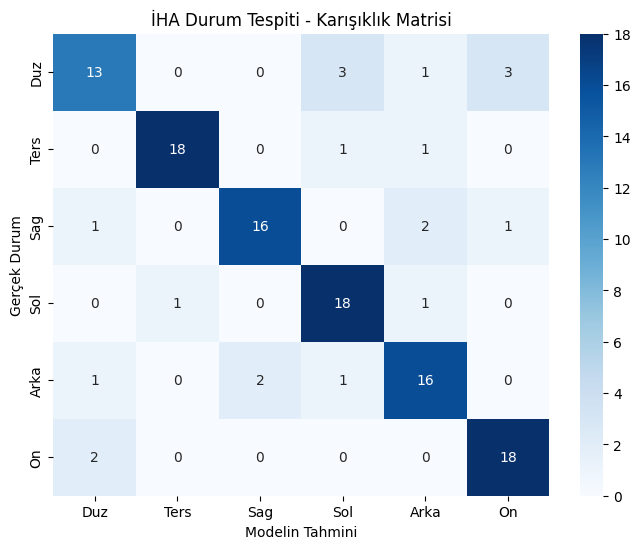

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Modelin tahminlerini al (Olasılık olarak değil, sınıf numarası olarak)
# predict: [[0.1, 0.8, ...], ...] verir. argmax ile en büyük olanın indeksini (sınıfı) alırız.
y_pred_prob = model.predict(scaledXtest)
y_pred = np.argmax(y_pred_prob, axis=1)

# 2. Matrisi Hesapla
cm = confusion_matrix(ytest, y_pred)

# 3. Çizdir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Duz', 'Ters', 'Sag', 'Sol', 'Arka', 'On'],
            yticklabels=['Duz', 'Ters', 'Sag', 'Sol', 'Arka', 'On'])
plt.xlabel('Modelin Tahmini')
plt.ylabel('Gerçek Durum')
plt.title('İHA Durum Tespiti - Karışıklık Matrisi')
plt.show()